In [1]:
import cv2
import numpy as np
from typing import List, Tuple
import matplotlib.pyplot as plt
from skimage.feature import peak_local_max


In [2]:
# Old version - not used but helpful
def harris_manual(
    input_img: np.ndarray,
    k: float = 0.04,
    neighborhood_size: int = 5,
    aperture_size: int = 3,
    threshold_ratio: float = 0.01,
    nms_radius: int = 5,
    border_type: int = cv2.BORDER_REFLECT_101
) -> Tuple[List[Tuple[int, int, float]], np.ndarray]:
    """
    Detect Harris corners in the input grayscale image
    Returns:
        corner_list: List of detected corners as (x, y, response_value)
        output_img: Original image with detected corners marked in red
    """
    try:
        # Validation
        # If even, rounds up to odd
        neighborhood_size = neighborhood_size | 1
        # Create copy for visualization
        if len(input_img.shape) == 2:
            output_img = cv2.cvtColor(input_img, cv2.COLOR_GRAY2BGR)
        else:
            output_img = input_img.copy()
            input_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
        # Enforce depth
        if input_img.dtype != np.float32:
            input_img = input_img.astype(np.float32)

        # Calculate gradients and their products
        dx = cv2.Sobel(input_img, cv2.CV_32F, 1, 0, ksize=aperture_size, borderType=border_type)
        dy = cv2.Sobel(input_img, cv2.CV_32F, 0, 1, ksize=aperture_size, borderType=border_type)
        i_xx = dx * dx
        i_xy = dx * dy
        i_yy = dy * dy

        # Sum of products using Gaussian window
        gaussian_kernel = cv2.getGaussianKernel(neighborhood_size, 0)  # sigma = 0.3*((ksize-1)*0.5 - 1) + 0.8
        gaussian_window = gaussian_kernel * gaussian_kernel.T

        # Apply Gaussian window to the gradient products
        sum_i_xx = cv2.filter2D(i_xx, cv2.CV_32F, gaussian_window, borderType=border_type)
        sum_i_xy = cv2.filter2D(i_xy, cv2.CV_32F, gaussian_window, borderType=border_type)
        sum_i_yy = cv2.filter2D(i_yy, cv2.CV_32F, gaussian_window, borderType=border_type)

        # Calculate Harris response
        det = (sum_i_xx * sum_i_yy) - (sum_i_xy * sum_i_xy)
        trace = sum_i_xx + sum_i_yy
        harris_response = det - k * (trace * trace)

        # Apply non-maximum suppression to the entire response map
        height, width = input_img.shape
        nms_response = np.zeros_like(harris_response)

        # Find local maxima, cannot handle plateau
        for y in range(nms_radius, height - nms_radius):
            for x in range(nms_radius, width - nms_radius):
                window = harris_response[y - nms_radius:y + nms_radius + 1, x - nms_radius:x + nms_radius + 1]
                if harris_response[y, x] == np.max(window) and harris_response[y, x] > 0:
                    nms_response[y, x] = harris_response[y, x]

        # Apply threshold
        max_response = np.max(nms_response)
        threshold = threshold_ratio * max_response

        # Collect corners
        corner_list = []
        for y in range(height):
            for x in range(width):
                if nms_response[y, x] > threshold:
                    corner_list.append((x, y, nms_response[y, x]))
                    cv2.circle(output_img, (x, y), 3, (0, 0, 255), 1)

        return corner_list, output_img

    except Exception as e:
        print(f"Error in Harris corner detection: {e}")
        return [], input_img


In [64]:
def harris_optimized(
        input_img: np.ndarray,
        k: float = 0.04,
        neighborhood_size: int = 5,
        aperture_size: int = 3,
        threshold_ratio: float = 0.01,
        nms_radius: int = 5,
        border_type: int = cv2.BORDER_REFLECT_101,
        window_type: str = 'gaussian'
) -> Tuple[List[Tuple[int, int, float]], np.ndarray, np.ndarray]:
    """
    Detect Harris corners in the input grayscale image
    Returns:
        List of detected corners as (x, y, response_value)
        Original image with detected corners marked in red
        Heatmap of Harris corner response
    """
    try:
        # 1. Param validation
        neighborhood_size = neighborhood_size | 1  # always odd
        aperture_size = aperture_size | 1  # always odd
        window_type = window_type.lower()  # always lowercase
        # Create copy for visualization
        if len(input_img.shape) == 2:
            output_img = cv2.cvtColor(input_img, cv2.COLOR_GRAY2BGR)
        else:
            output_img = input_img.copy()
            input_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
        # Enforce depth
        if input_img.dtype != np.float32:
            input_img = input_img.astype(np.float32)

        # 2. Calculate gradients and products
        dx = cv2.Sobel(input_img, cv2.CV_32F, 1, 0, ksize=aperture_size, borderType=border_type)
        dy = cv2.Sobel(input_img, cv2.CV_32F, 0, 1, ksize=aperture_size, borderType=border_type)
        i_xx = dx * dx
        i_xy = dx * dy
        i_yy = dy * dy

        # 3. Sum the products of gradients
        if window_type == 'gaussian':
            kernel_1d = cv2.getGaussianKernel(neighborhood_size, 0)  # sigma = 0.3*((ksize-1)*0.5 – 1) + 0.8
        elif window_type == 'binary' or window_type == 'uniform':
            kernel_1d = np.ones(neighborhood_size) / neighborhood_size
        else:
            raise Exception("unknown window type")
        sum_i_xx = cv2.sepFilter2D(i_xx, cv2.CV_32F, kernel_1d, kernel_1d, borderType=border_type)
        sum_i_xy = cv2.sepFilter2D(i_xy, cv2.CV_32F, kernel_1d, kernel_1d, borderType=border_type)
        sum_i_yy = cv2.sepFilter2D(i_yy, cv2.CV_32F, kernel_1d, kernel_1d, borderType=border_type)

        # 4.Calculate Harris response
        det = (sum_i_xx * sum_i_yy) - (sum_i_xy * sum_i_xy)
        trace = sum_i_xx + sum_i_yy
        harris_response = det - k * (trace * trace)

        # 5. Apply NMS, then relative thresholding based on max value
        coordinates: Tuple[List[int], List[int]] = peak_local_max(harris_response, min_distance=nms_radius, threshold_rel=threshold_ratio)

        # 6. Post-processing steps
        # Create list of corners
        corner_list: List[Tuple[int, int, float]] = [(x, y, harris_response[y, x]) for y, x in coordinates]

        # Mark corner, radius based on response strength
        max_response: float = max(score for _, _, score in corner_list) or 1.0
        for x, y, score in corner_list:
            radius = int(3 + (score / max_response) * 10)
            cv2.circle(output_img, (x, y), radius, (0, 0, 255), 1)

        # Create response heatmap
        norm_response = cv2.normalize(harris_response, None, 0, 255, cv2.NORM_MINMAX)
        heatmap = cv2.applyColorMap(norm_response.astype(np.uint8), cv2.COLORMAP_JET)

        return corner_list, output_img, heatmap

    except Exception as e:
        print(f"Error in Harris corner detection: {e}")
        return [], input_img, np.zeros((*input_img.shape[:2], 3), dtype=np.float32)


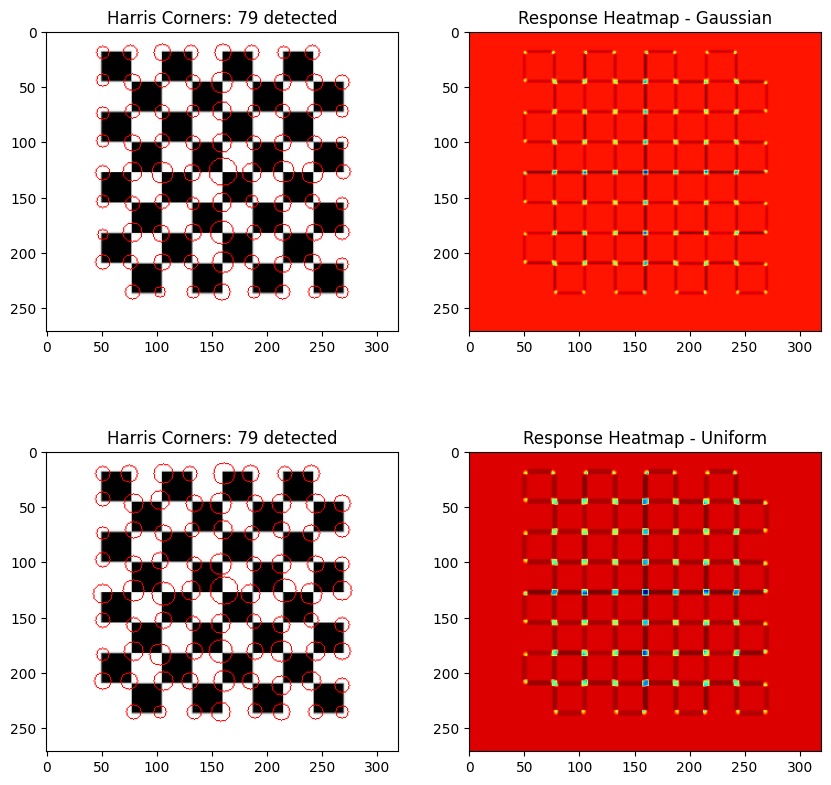

Image dimensions: (272, 320)


In [65]:
# Test Harris with a regular pattern, on Gaussian and uniform window
def test_checker():
    #
    checkerboard = cv2.imread("materials/calibration/checkerboard.bmp", cv2.IMREAD_GRAYSCALE)
    corners, output_img, heatmap = harris_optimized(checkerboard)
    corners2, output_img2, heatmap2 = harris_optimized(checkerboard, window_type='uniform')

    plt.figure(figsize=(10, 10))

    plt.subplot(221)
    plt.imshow(cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB))
    plt.title(f'Harris Corners: {len(corners)} detected')

    plt.subplot(222)
    plt.imshow(heatmap)
    plt.title('Response Heatmap - Gaussian')

    plt.subplot(223)
    plt.imshow(cv2.cvtColor(output_img2, cv2.COLOR_BGR2RGB))
    plt.title(f'Harris Corners: {len(corners2)} detected')

    plt.subplot(224)
    plt.imshow(heatmap2)
    plt.title('Response Heatmap - Uniform')

    plt.show()
    print(f"Image dimensions: {checkerboard.shape}")


# NOTE: Gaussian window → center/axis pattern in regular grids
# position-dependent weighting amplified by det-trace calculations
# use uniform window for global uniformity
test_checker()


Image dimensions: (384, 512)


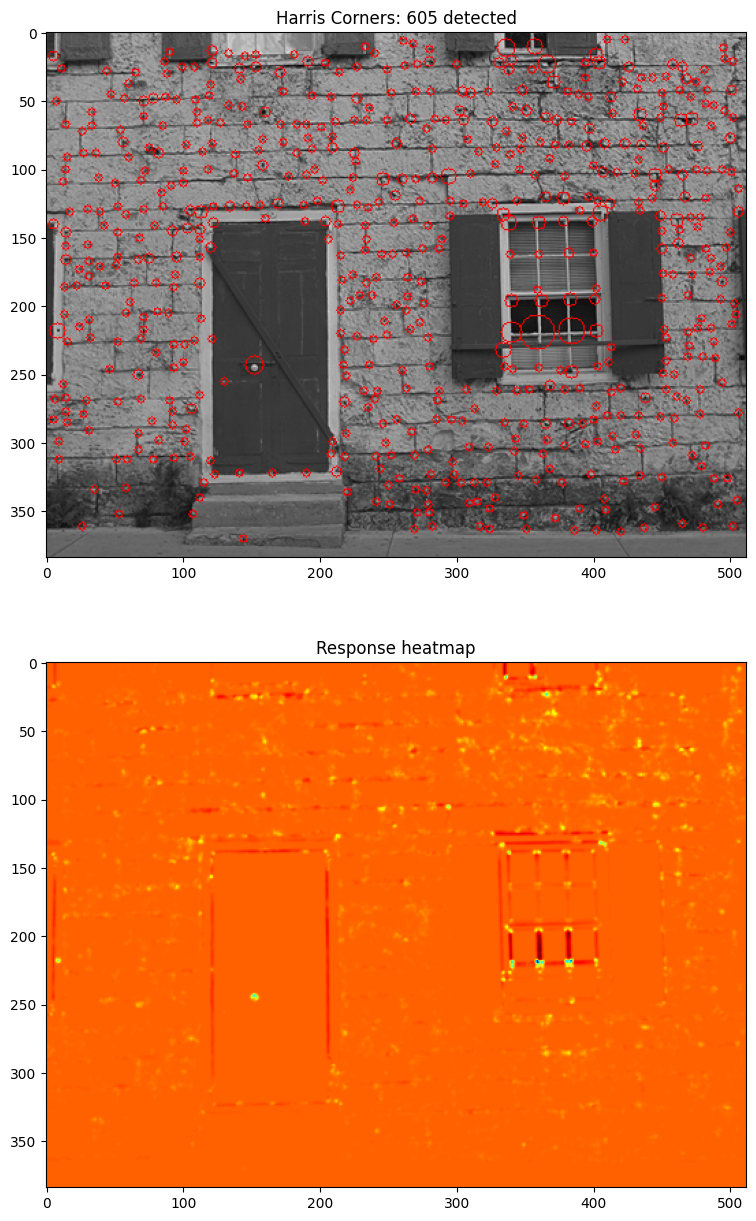

Number of corners detected: 605
Response values range: 118019392.00 to 11793811456.00


In [66]:
def test_reference_image():
    img = cv2.imread("tid2013/reference_images/I01.BMP", cv2.IMREAD_GRAYSCALE)
    print(f"Image dimensions: {img.shape}")
    corners, output_img, heatmap = harris_optimized(img)

    plt.figure(figsize=(10, 15))

    plt.subplot(2, 1, 1)
    plt.imshow(cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB))
    plt.title(f'Harris Corners: {len(corners)} detected')

    plt.subplot(2, 1, 2)
    plt.imshow(heatmap)
    plt.title('Response heatmap')


    plt.show()

    # Basic checks
    print(f"Number of corners detected: {len(corners)}")
    if len(corners) > 0:
        print(f"Response values range: {min([c[2] for c in corners]):.2f} to {max([c[2] for c in corners]):.2f}")


test_reference_image()
